### Repeatable, Parallel Model Training and Model Tracking and Analysis  
  
In this notebook, you will use Azure Machine learning to create a repeatable, scaleable model training framework. Key concepts in this notebook are:  
  
1. **Data partition by column(s)**
   - In order to parallelize training by partition you will leverage the [data partition component](../src/components/partition_data/) to parse and send chunks of data to be trained.
   - In this case, data is partitioned by unique Store + Brand combinations
2. **Custom model training script**
   - The [model trianing script](../src/parallel_train.py) is custom and interchangeable so it can be easily adapted for changing needs
   -  In this case, the trianing script is a _very_ simple Gradient Boosted Regressor from scikit-learn
3. **Parallel model training on an ephermoral compute cluster**
   - The training utilizes the compute cluster from [Step 0 - Steup](./0_setup.ipynb) to train a model on each data partition in parallel
   - The cluster can be scaled vertically (node size) or horizontally (node count) as needed
   - The cluster is totally ephemoral - scaling down to zero running nodes when idle
4. **Azure Machine Learning Model Registry**
   - This notebook uses AML Model Registry to track model versions, artifacts, and metadata in a seamless and managed process
5. **MLflow alanysis across experiments and/or training jobs**
   - Using AML integration with MLFlow you are able to query models across experiments and/or training runs to analyze results
   - Building on this framework allows for a scaleable way to analyze 100,000+ models. Including answers to quesitons like:
     - Which model version has the lowest RMSE for a given Store/brand?
     - How do training and testing metrics compare between Experiment A and Experiment B?
     - How long on average did it take to train a model in Job 1?

In [ ]:
# import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient, Input, Output, load_component
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml.parallel import parallel_run_function, RunFunction
from dotenv import load_dotenv, find_dotenv
import os
import mlflow

In [ ]:
# Initialize ML Client
load_dotenv(find_dotenv(), override=True)

# authenticate
credential = DefaultAzureCredential(tenantid=os.environ.get('TENANT_ID'))

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

### Prepare, Define, and Run Training Pipeline

In [ ]:
# Load data preparation component
partition_data = load_component(source="../src/components/partition_data/partition_data.yaml")

In [ ]:
# Acess data asset
data_name = "oj-sim-sales-train"
train_data_asset = ml_client.data.get(data_name, label='latest')
print(train_data_asset.path)

In [ ]:
# Define compute target (created in setup notebook)
cpu_compute_target = "mm-cpu-cluster"

# Define runtime environment
custom_env_name = "mm-remote-env-py310"

# Define tracking URI
azureml_tracking_uri = ml_client.workspaces.get(ml_client.workspace_name).mlflow_tracking_uri

In [ ]:
# Declare parallel job, with a run_function task
many_model_training_with_partition_keys = parallel_run_function(
    name="distributed_training",
    display_name="Many Model Training",
    description="parallel job to train many models with partition_keys on mltable input",
    inputs=dict(
        data_source=Input(
            type=AssetTypes.MLTABLE,
            description="Input mltable with predefined partition format.",
            mode=InputOutputModes.DIRECT,  # [Important] To use 'partition_keys', input MLTable is required to use 'direct' mode.
        ),
        drop_cols=Input(
            type="string",
            description="Columns need to be dropped before training. Split by comma.",
        ),
        target_col=Input(
            type="string",
            description="The column name for label of the input data.",
        ),
        date_col=Input(
            type="string",
            description="The column name for datatime.",
        ),
        tracking_uri=Input(
            type="string",
            description="Mlflow tracking uri for the AML workspace",
        ),
    ),
    outputs=dict(
        model_folder=Output(
            type=AssetTypes.URI_FOLDER,
            mode=InputOutputModes.RW_MOUNT,
        )
    ),
    input_data="${{inputs.data_source}}",  # Define which input data will be splitted into mini-batches
    partition_keys=["Store","Brand"],  # Use 'partition_keys' as the data division method. This method requires MLTable input with partition setting pre-defined in MLTable artifact.
    instance_count=10,  # Use X nodes from compute cluster to run this parallel job.
    max_concurrency_per_instance=2,  # Create 2 worker processors in each compute node to execute mini-batches.
    error_threshold=-1,  # Monitor the failures of item processed by the gap between mini-batch input count and returns. 'Many model training' scenario doesn't fit this setting and '-1' means ignore counting failure items by mini-batch returns.
    mini_batch_error_threshold=5,  # Monitor the failed mini-batch by exception, time out, or null return. When failed mini-batch count is higher than this setting, the parallel job will be marked as 'failed'.
    retry_settings=dict(
        max_retries=1,  # Define how many retries when mini-batch execution is failed by exception, time out, or null return.
        timeout=120,  # Define the timeout in second for each mini-batch execution. (in seconds)
    ),
    logging_level="WARNING", # DEBUG, INFO, WARNING, ERROR, ETC
    task=RunFunction(
        code="../src/",
        entry_script="parallel_train.py",
        environment=ml_client.environments.get(custom_env_name, label="latest"),
        program_arguments="--drop_cols ${{inputs.drop_cols}} "  # Passthrough input parameters into parallel_train script.
        "--target_col ${{inputs.target_col}} "
        "--date_col ${{inputs.date_col}} "
        "--model_folder ${{outputs.model_folder}} "
        "--tracking_uri ${{inputs.tracking_uri}} ",
    ),
)

In [ ]:
# Build Pipeline
# Declare the overall input of the job.
input_oj_data = Input(
    path=train_data_asset.path,
    type=AssetTypes.URI_FILE,
    mode=InputOutputModes.RO_MOUNT,
)

# Declare pipeline structure.
@pipeline(display_name="parallel train pipeline")
def parallel_training_pipeline(pipeline_input_data):
    
    # Declare 1st data partition command job.
    partition_job = partition_data(
        data_source=pipeline_input_data,
        partition_keys="Store,Brand",
    )

    # Declare 2nd parallel model training job.
    parallel_train = many_model_training_with_partition_keys(
        data_source=partition_job.outputs.tabular_output_data,
        drop_cols="Advert,Store,Brand",
        target_col="Revenue",
        date_col="WeekStarting",
        tracking_uri= azureml_tracking_uri,
    )
    
    # User could override parallel job run-level property when invoke that parallel job/component in pipeline.
    # parallel_train.resources.instance_count = 5
    # parallel_train.max_concurrency_per_instance = 2
    # parallel_train.mini_batch_error_threshold = 10

# Create pipeline instance
training_pipeline = parallel_training_pipeline(pipeline_input_data=input_oj_data,)

# Set pipeline level compute
training_pipeline.settings.default_compute = cpu_compute_target
print(training_pipeline)

In [ ]:
# Submit training pipeline
pipeline_job = ml_client.jobs.create_or_update(
    training_pipeline,
    experiment_name="many-models-parallel-training-job",
)

Navigate to the Portal to view pipeline progress, and wait for the pipeline to complete.  
  
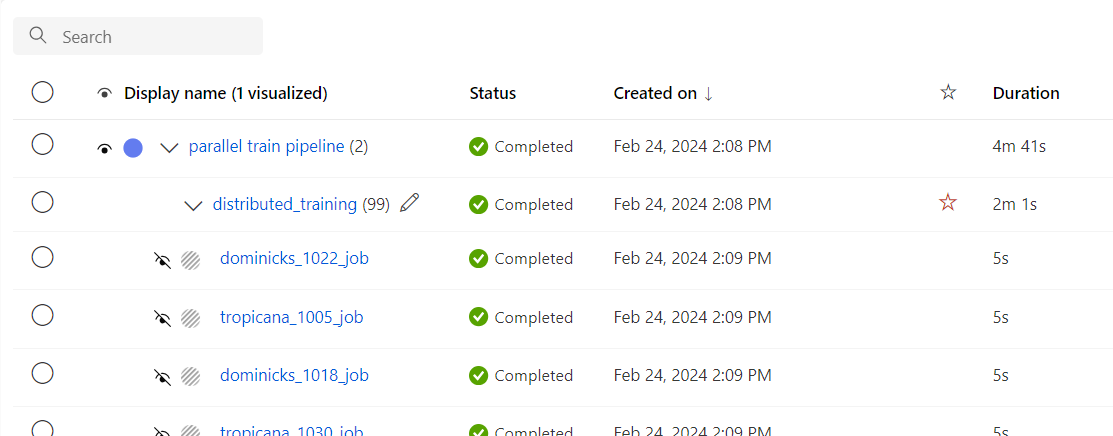

### Analyze Results using MLFlow

In [ ]:
# Analyze results

azureml_tracking_uri = ml_client.workspaces.get(ml_client.workspace_name).mlflow_tracking_uri
mlflow.set_tracking_uri(azureml_tracking_uri)

EXPIREMENTS = ["many-models-parallel-training-job"]

mlflow.search_runs(experiment_names= EXPIREMENTS,
                   filter_string="tags.store = '1013' and \
                                  tags.brand = 'tropicana' "
                )